In [1]:
import pandas as pd
from pyproj import Geod
import random, string
# you don't NEED my library, but why not have prettier plots??
from jb4jupyter import *
colabprettyplot('d',cmapp='matter',clamp=0.25,lines=4)


us_conf = pd.read_csv('time_series_covid19_confirmed_US.csv',error_bad_lines=False,delimiter=',')
us_dead = pd.read_csv('time_series_covid19_deaths_US.csv',error_bad_lines=False,delimiter=',')
us_conf.keys()

Index(['UID', 'iso2', 'iso3', 'code3', 'FIPS', 'Admin2', 'Province_State',
       'Country_Region', 'Lat', 'Long_', 'Combined_Key', '1/22/20', '1/23/20',
       '1/24/20', '1/25/20', '1/26/20', '1/27/20', '1/28/20', '1/29/20',
       '1/30/20', '1/31/20', '2/1/20', '2/2/20', '2/3/20', '2/4/20', '2/5/20',
       '2/6/20', '2/7/20', '2/8/20', '2/9/20', '2/10/20', '2/11/20', '2/12/20',
       '2/13/20', '2/14/20', '2/15/20', '2/16/20', '2/17/20', '2/18/20',
       '2/19/20', '2/20/20', '2/21/20', '2/22/20', '2/23/20', '2/24/20',
       '2/25/20', '2/26/20', '2/27/20', '2/28/20', '2/29/20', '3/1/20',
       '3/2/20', '3/3/20', '3/4/20', '3/5/20', '3/6/20', '3/7/20', '3/8/20',
       '3/9/20', '3/10/20', '3/11/20', '3/12/20', '3/13/20', '3/14/20',
       '3/15/20', '3/16/20', '3/17/20', '3/18/20', '3/19/20', '3/20/20',
       '3/21/20', '3/22/20', '3/23/20', '3/24/20', '3/25/20', '3/26/20',
       '3/27/20', '3/28/20', '3/29/20', '3/30/20', '3/31/20', '4/1/20',
       '4/2/20', '4/3/20', '4

In [2]:
#Get distance between pairs of lat-lon points
def Distance(lat1,lon1,lat2,lon2):
    wgs84_geod = Geod(ellps='WGS84') #Distance will be measured on this ellipsoid - more accurate than a spherical method
    az12,az21,dist = wgs84_geod.inv(lon1,lat1,lon2,lat2) #Yes, this order is correct
    return dist

distances = np.zeros(((us_conf.shape[0]),(us_conf.shape[0])))
for num1,c1 in enumerate(zip(us_conf['Lat'],us_conf['Long_'])):
    for num2,c2 in enumerate(zip(us_conf['Lat'],us_conf['Long_'])):
        distances[num1,num2] = Distance(c1[0],c1[1],c2[0],c2[1])

proximity = -(distances - distances.max())/distances.max()

In [4]:
proximity

array([[ 1.        ,  0.67744866,  0.67677698, ..., -0.        ,
        -0.        , -0.        ],
       [ 0.67744866,  1.        ,  0.98860966, ...,  0.12279878,
         0.12279878,  0.12279878],
       [ 0.67677698,  0.98860966,  1.        , ...,  0.12128436,
         0.12128436,  0.12128436],
       ...,
       [-0.        ,  0.12279878,  0.12128436, ...,  1.        ,
         1.        ,  1.        ],
       [-0.        ,  0.12279878,  0.12128436, ...,  1.        ,
         1.        ,  1.        ],
       [-0.        ,  0.12279878,  0.12128436, ...,  1.        ,
         1.        ,  1.        ]])

# SEIRS County by County Model

The following ODE describes the model:

$
\begin{align}
 \frac{dS}{dt} &= - \frac{\beta I S}{N}+\zeta R \\
 \frac{dE}{dt} &=\frac{\beta I S}{N}-\sigma E\\
 \frac{dI}{dt} &= \sigma E - \gamma I \\ 
 \frac{dR}{dt} &= \gamma I - \zeta R\\
 N &= S + E + I + R
\end{align}
$ 

ref: https://www.idmod.org/docs/hiv/model-seir.html

In [163]:
def uphyper(beta,zeta,sigma,gamma):
    # TODO: @tyler
    sizer = beta.shape[0]
    for i in np.arange(np.random.randint(sizer)):
        a = np.random.randint(sizer)
        b = np.random.randint(sizer)
        beta[a,b] = beta[a,b]*(np.random.random()+0.5) # scale values by 50% to 100%
        zeta[a,b] = zeta[a,b]*(np.random.random()+0.5) # scale values by 50% to 100%
        sigma[a,b] = sigma[a,b]*(np.random.random()+0.5) # scale values by 50% to 100%
        gamma[a,b] = gamma[a,b]*(np.random.random()+0.5) # scale values by 50% to 100%
    return (beta,zeta,sigma,gamma)

def SEIRS(S,E,I,R,N,beta,zeta,sigma,gamma):
    beta,zeta,sigma,gamma = uphyper(beta,zeta,sigma,gamma)
    dSdt = -np.matmul(beta,I)*S/N+np.matmul(zeta,R)
    dEdt = np.matmul(beta,I)*S/N-np.matmul(sigma,E)
    dIdt = np.matmul(sigma,E)-np.matmul(gamma,I)
    dRdt = np.matmul(gamma,I)-np.matmul(zeta,R)
    Sn = S + dSdt
    En = E + dEdt
    In = I + dIdt
    Rn = R + dRdt
    Sn[Sn<0] = 0
    En[En<0] = 0
    In[In<0] = 0
    Rn[Rn<0] = 0
    Sn[Sn>N] = N
    En[En>N] = N
    In[In>N] = N
    Rn[Rn>N] = N
    return (Sn,En,In,Rn,beta,zeta,sigma,gamma)


$N \equiv population$

$S \equiv susceptible$

$E \equiv exposed$

$I \equiv infected$

$R \equiv removed$

(149556123.20000002, 16617348.800000003, 16, 0)

$\beta \equiv average \ contact$

$\gamma \equiv recovery\ rate$

$\sigma \equiv incubation\ rate$

$\zeta \equiv re-susceptible\ rate$

In [233]:

# beta

Set some number of days (`tottime` and let it run!)

223.41655679457654 2.576567806603489 18.63329802008892 0.09488549109721348


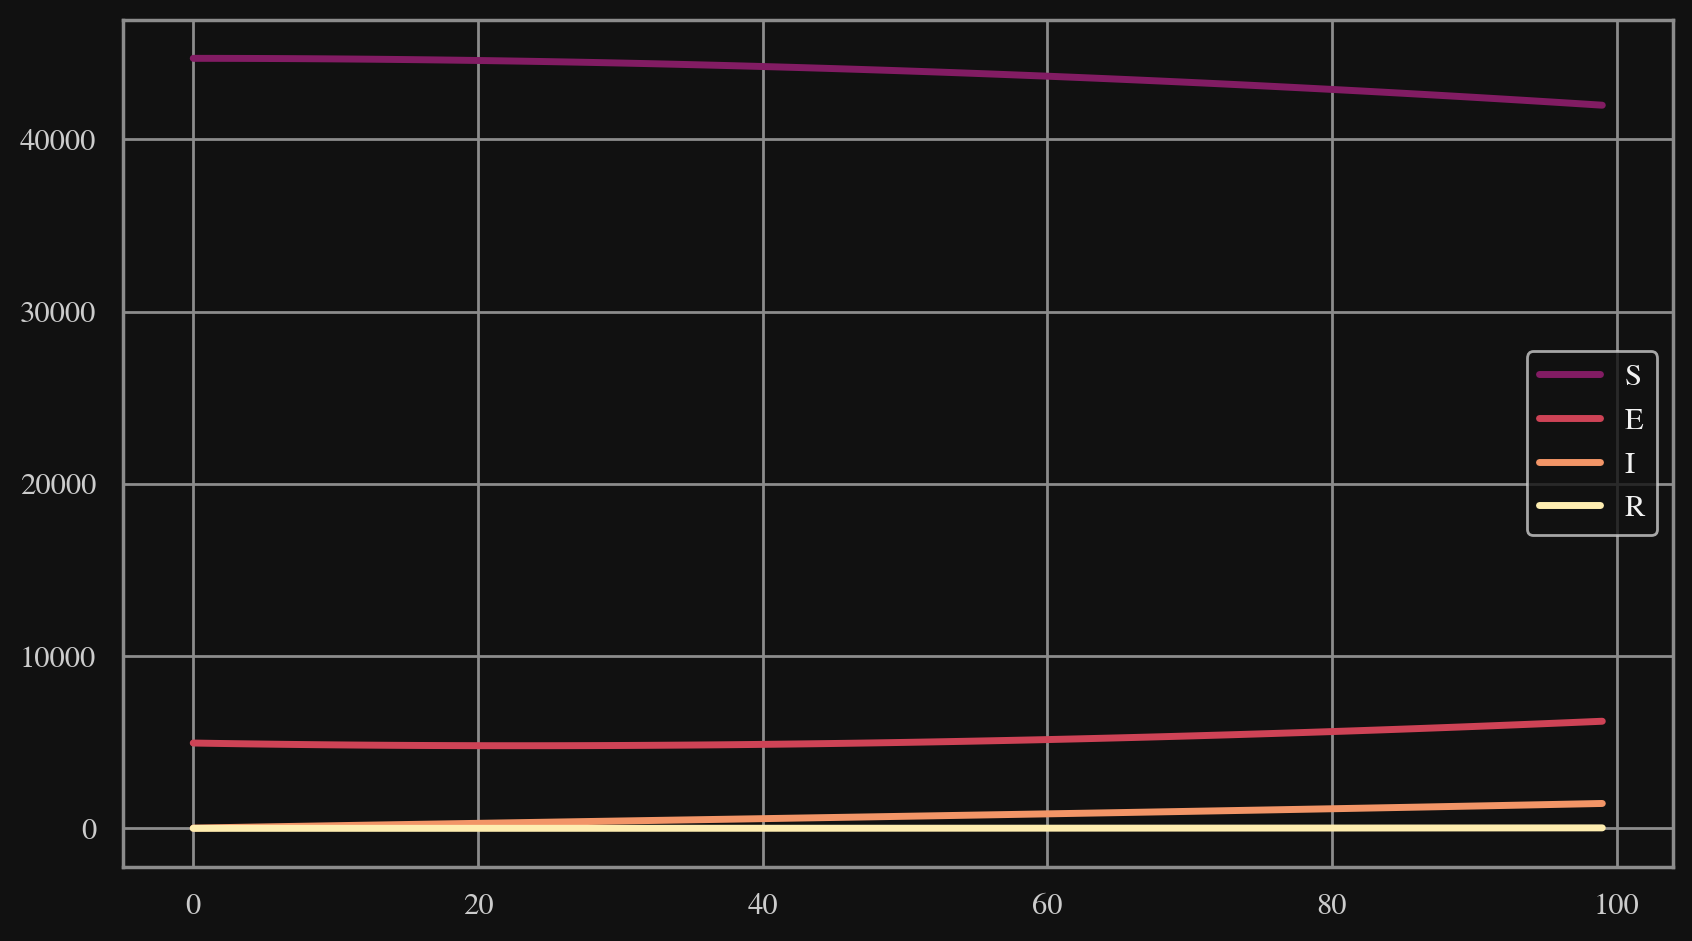

21.674397041185635 7.602371745545979 90.60679100370496 0.009096358378503422


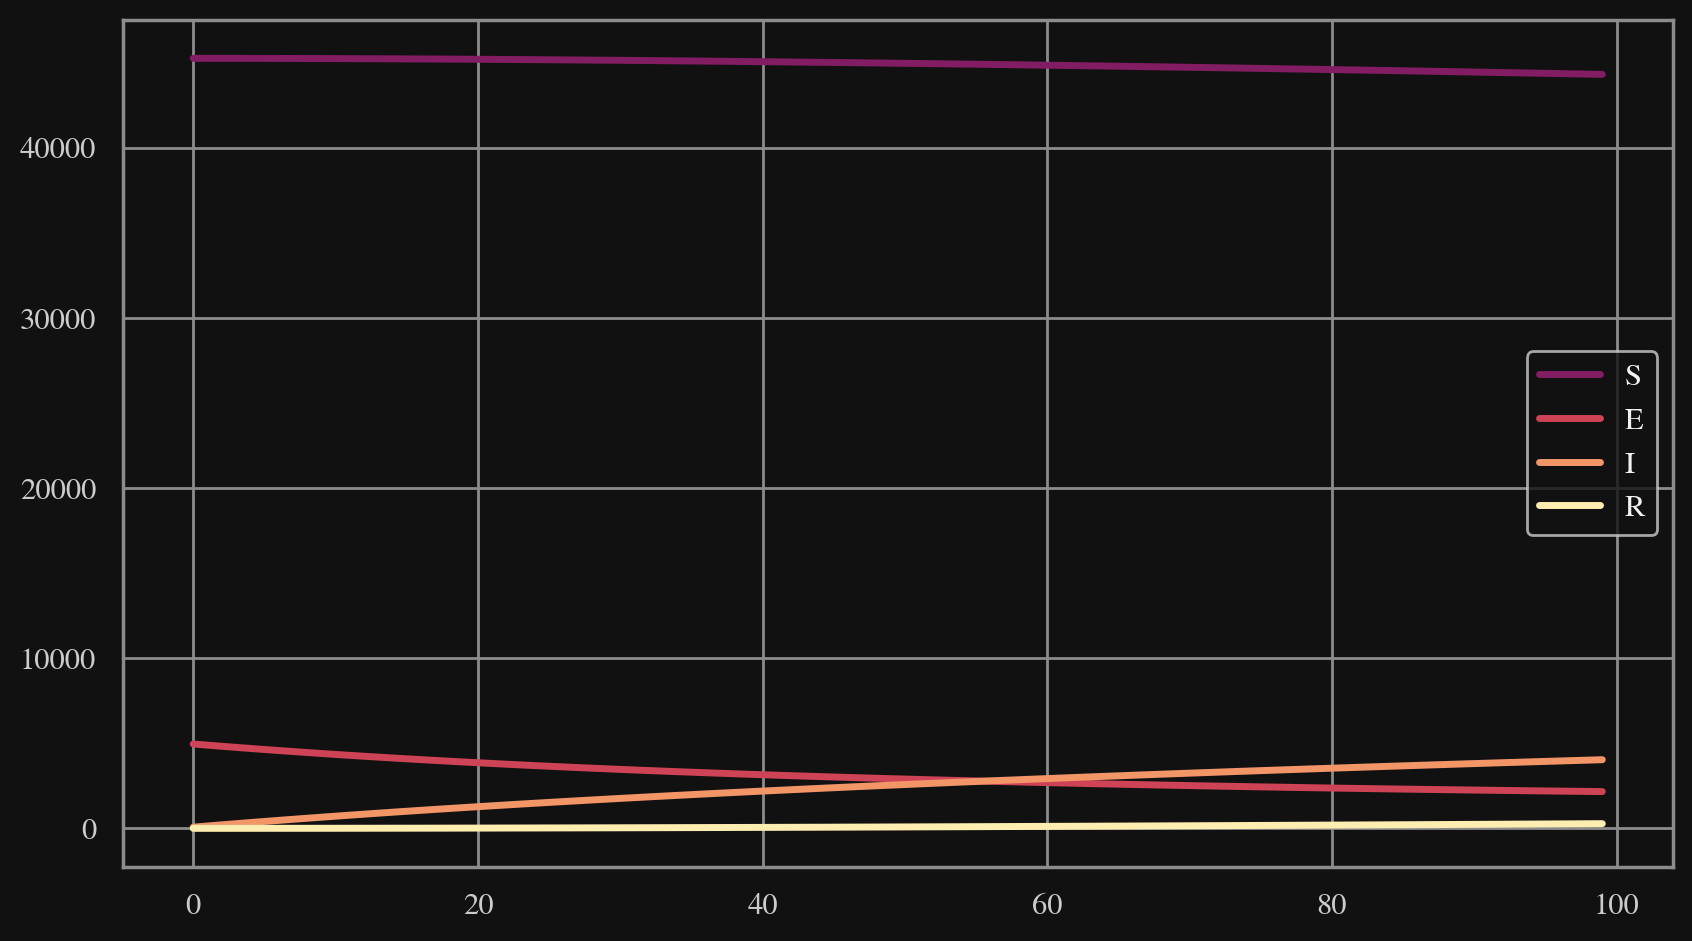

119.77750548589594 7.2480033793472565 26.208944611379714 0.08706307767450146


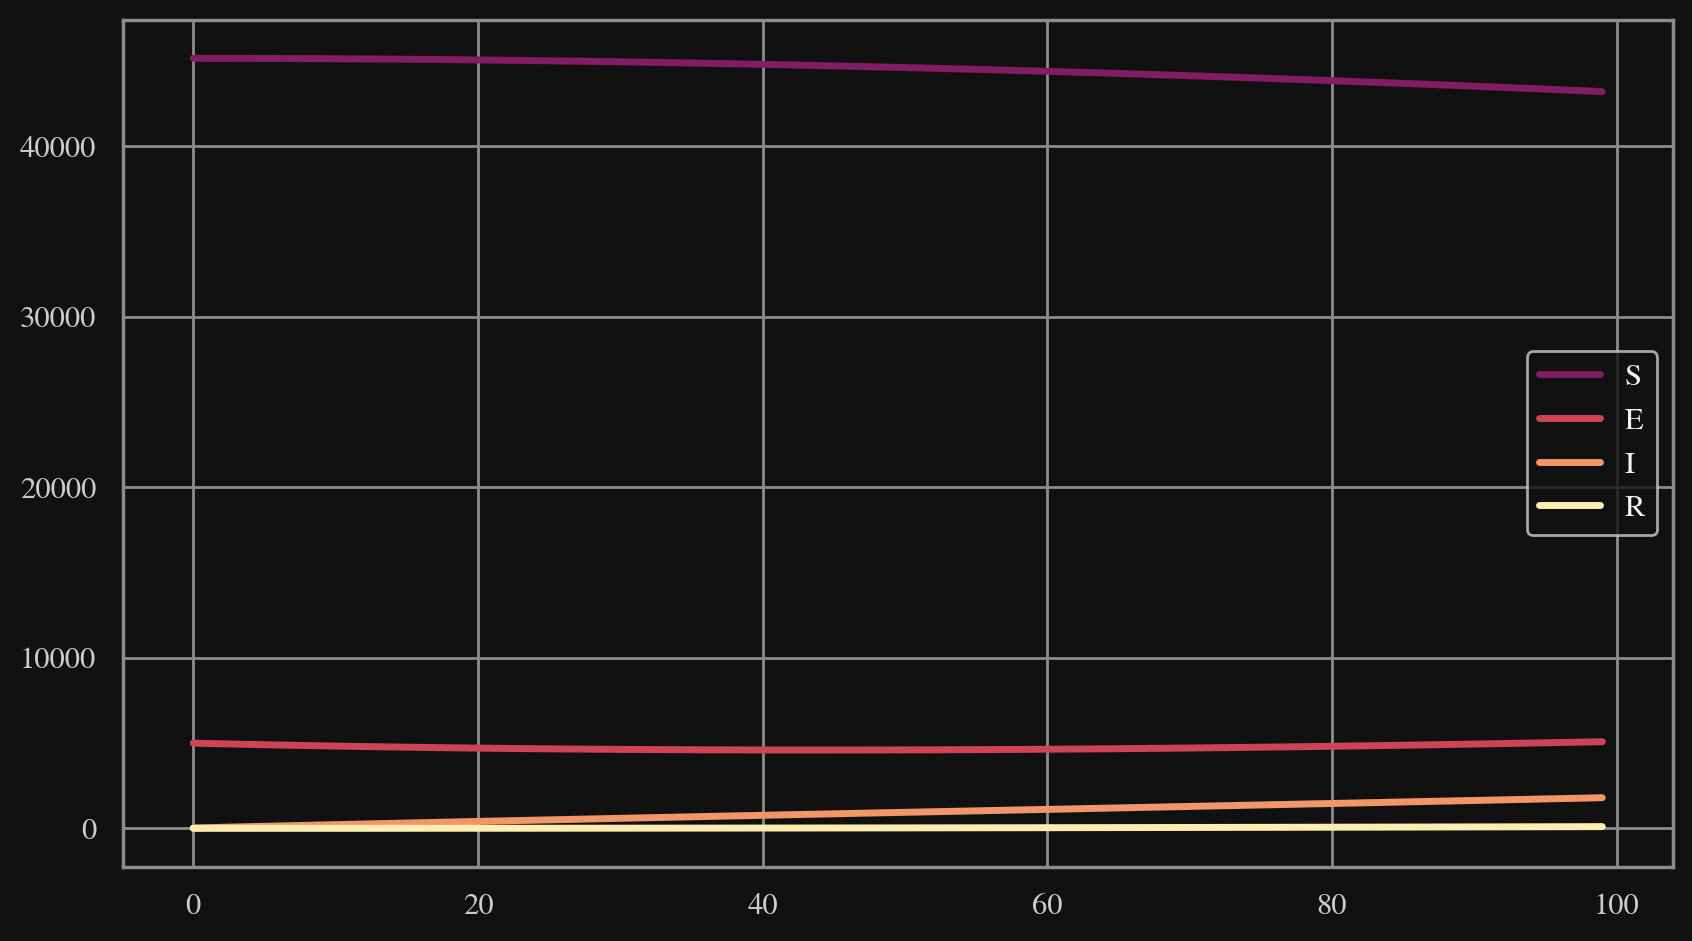

51.34654160102687 3.954286083240454 86.25747467478185 0.05513436682197834


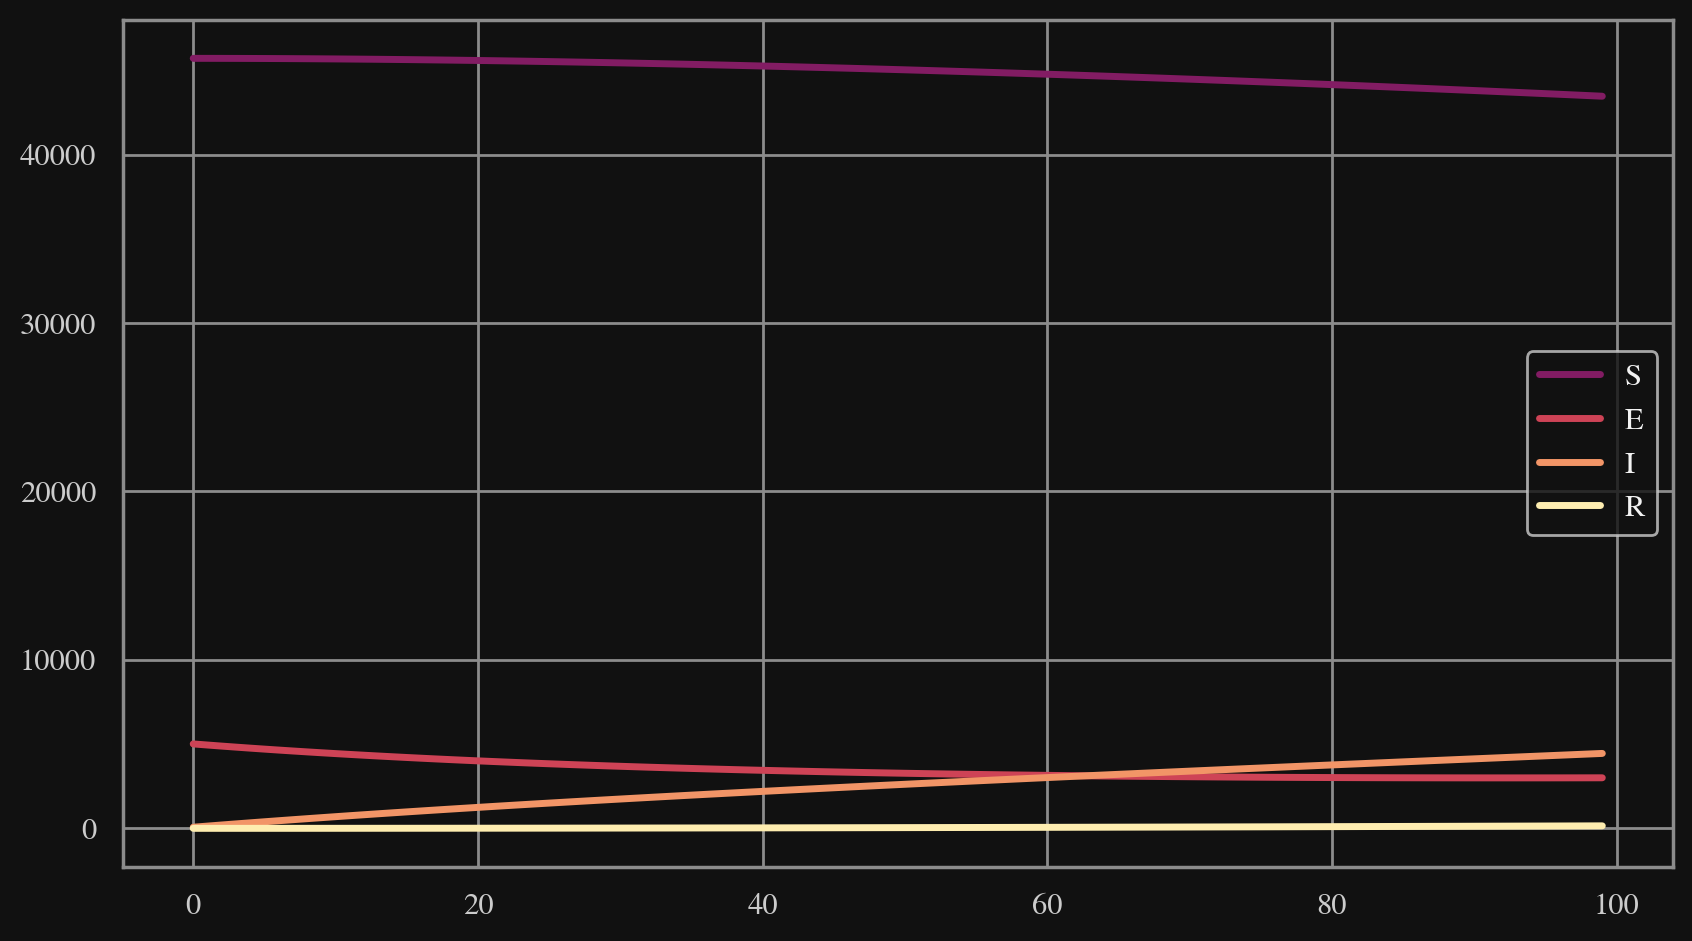

209.92908749050036 4.578878230396639 54.52007405315772 0.038508768428810555


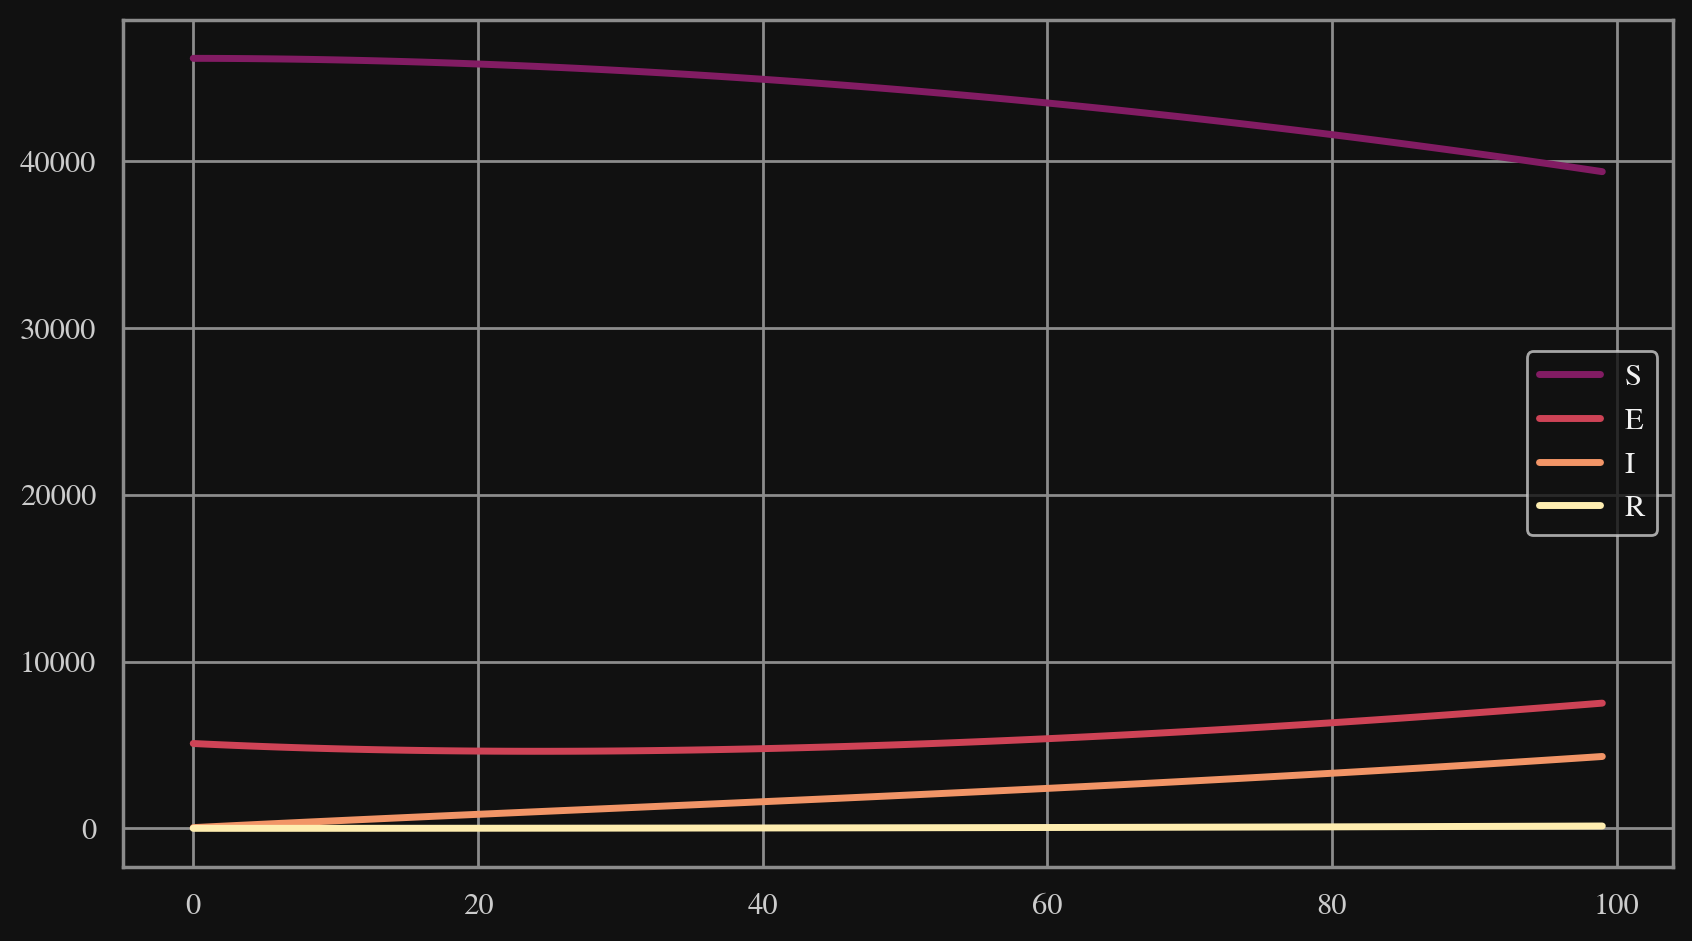

154.93051288587935 9.081573647432561 64.95298390588461 0.06667765247283551


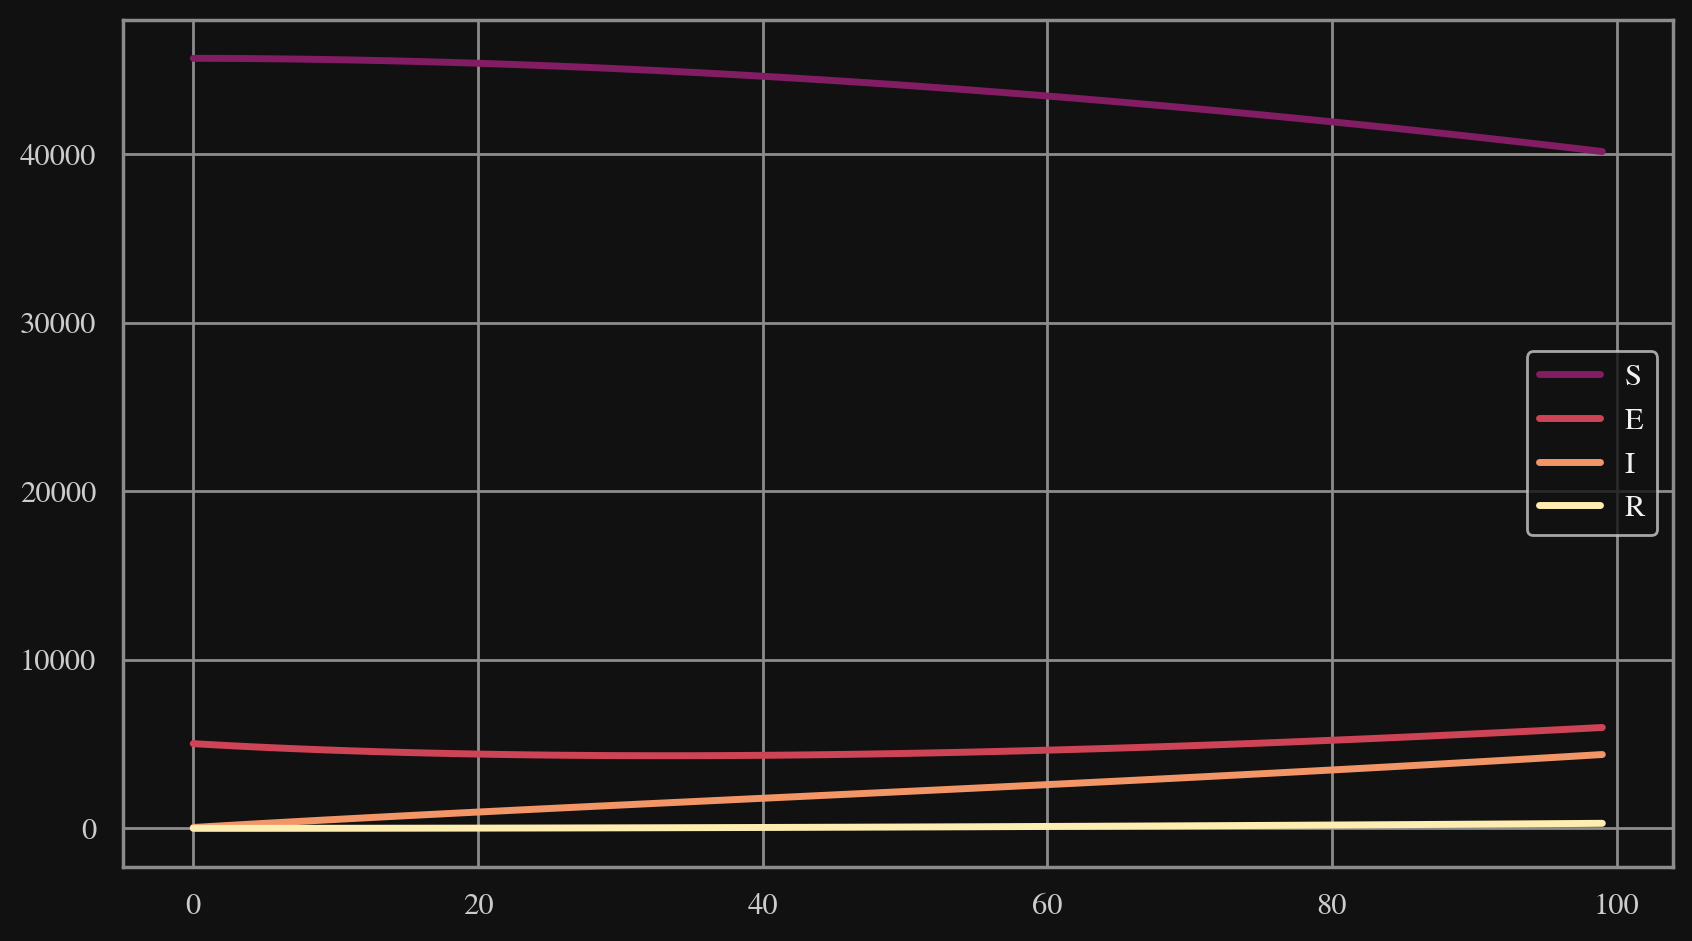

231.58643298731914 8.984712522119427 2.95088285731262 0.021861432583330998


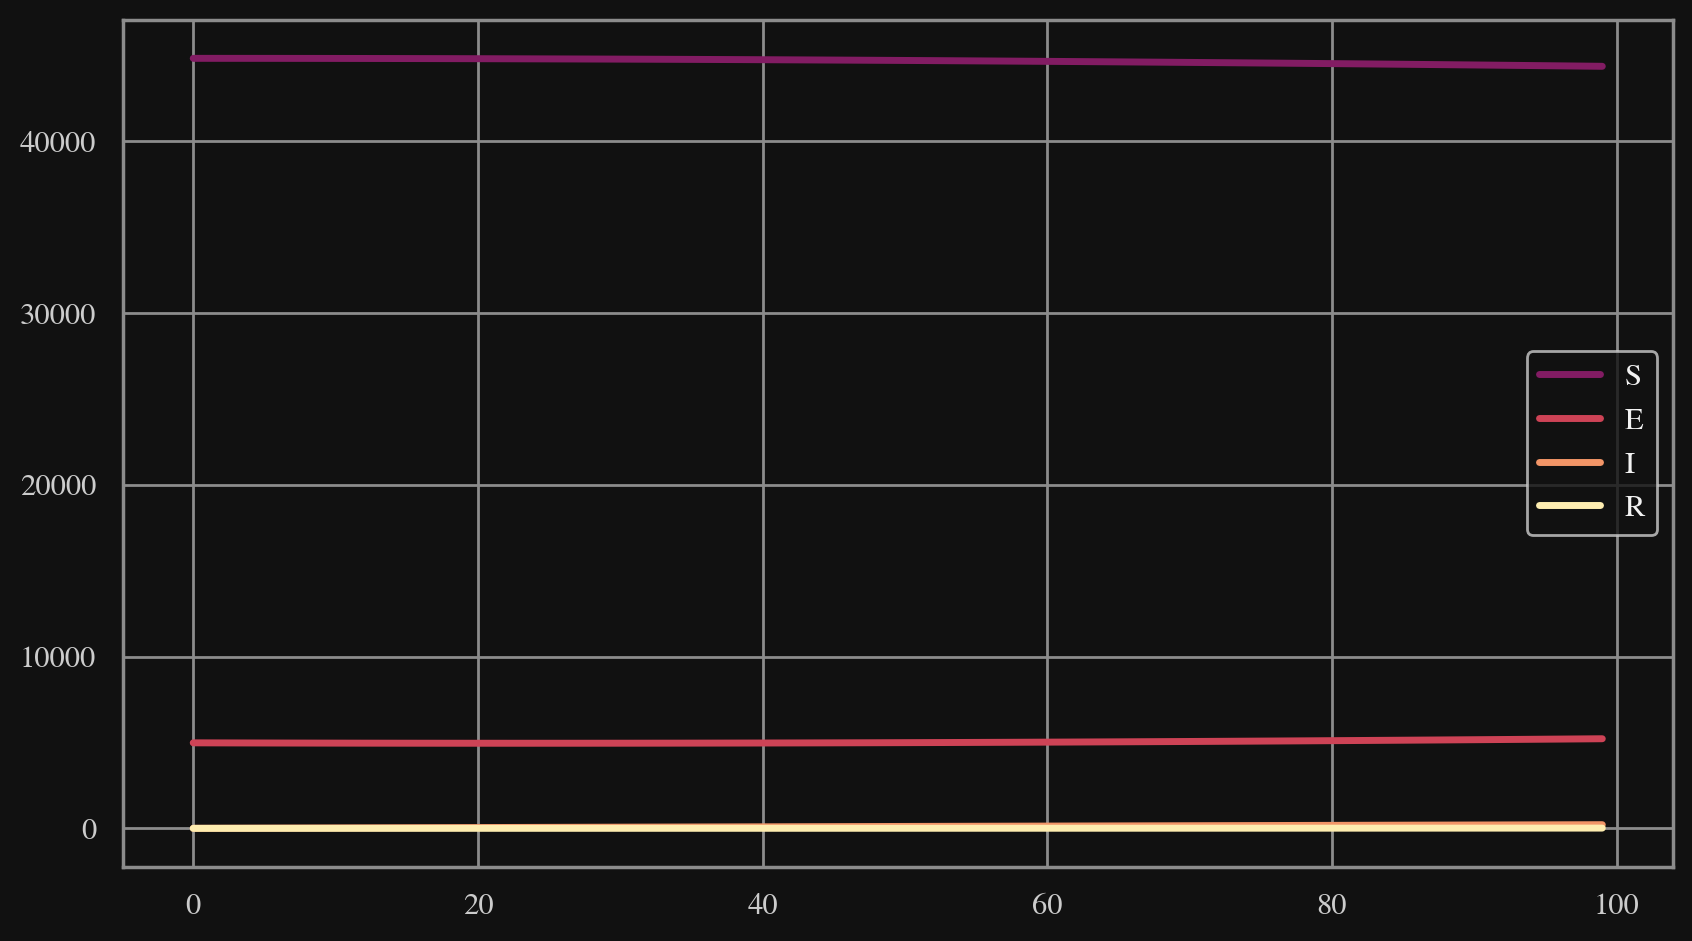

213.57010895007176 1.7889577424231708 90.41082240322325 0.04191590870852077


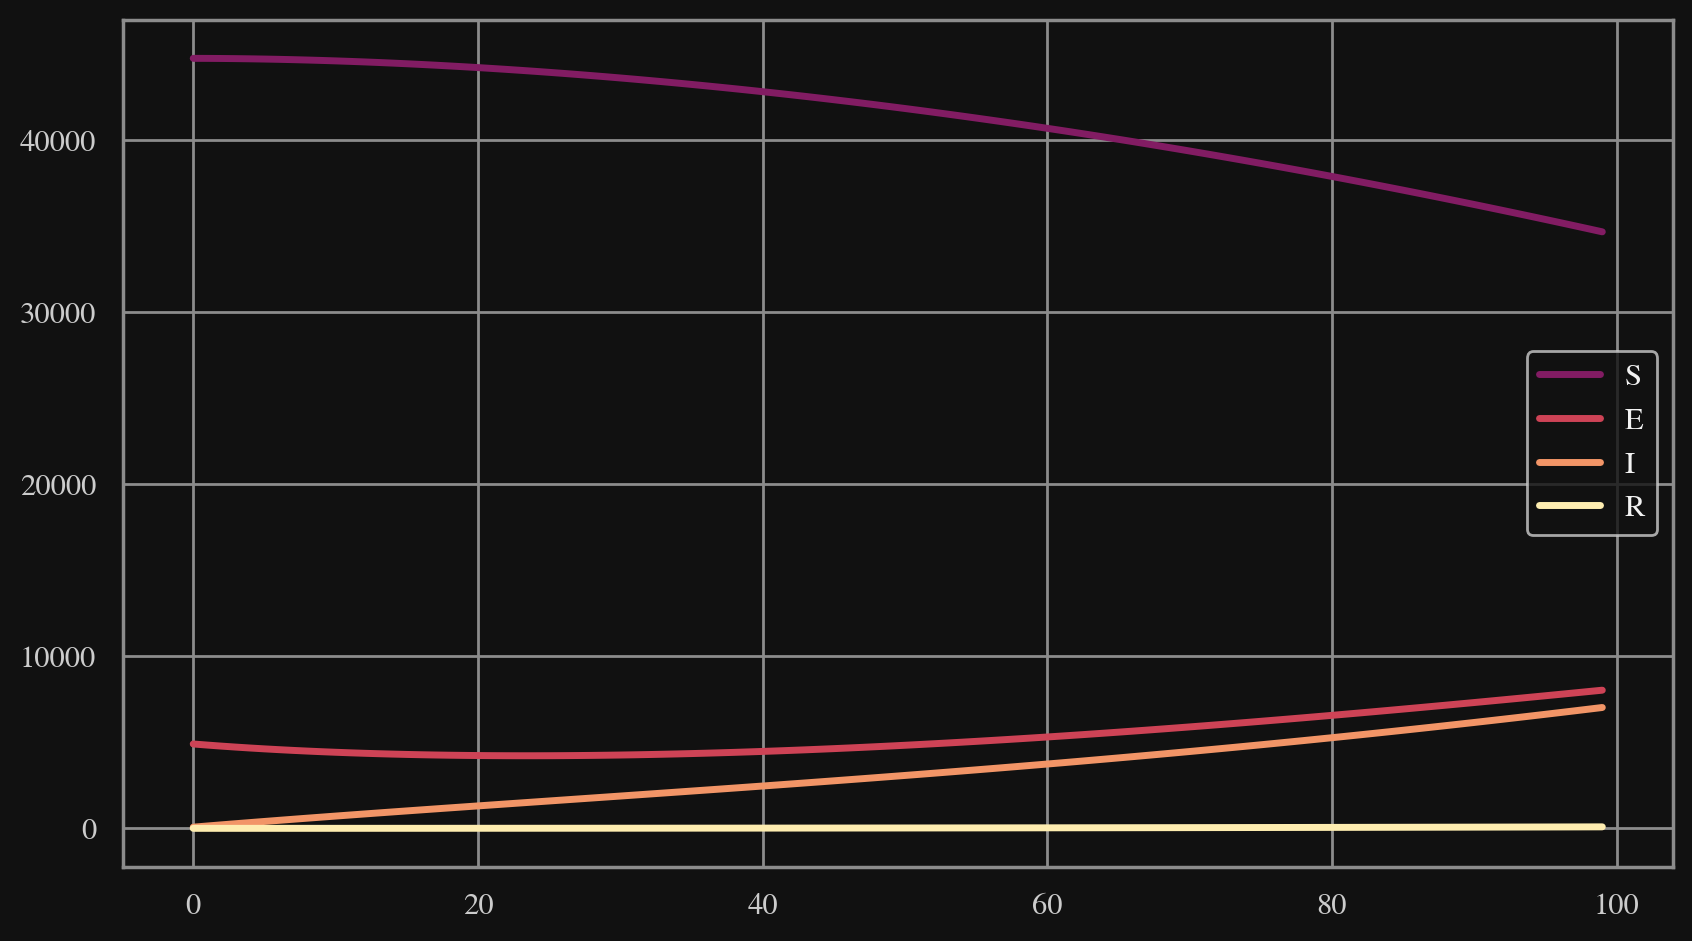

118.63725442638801 6.920866215103904 25.697563300898274 0.09059852063001117


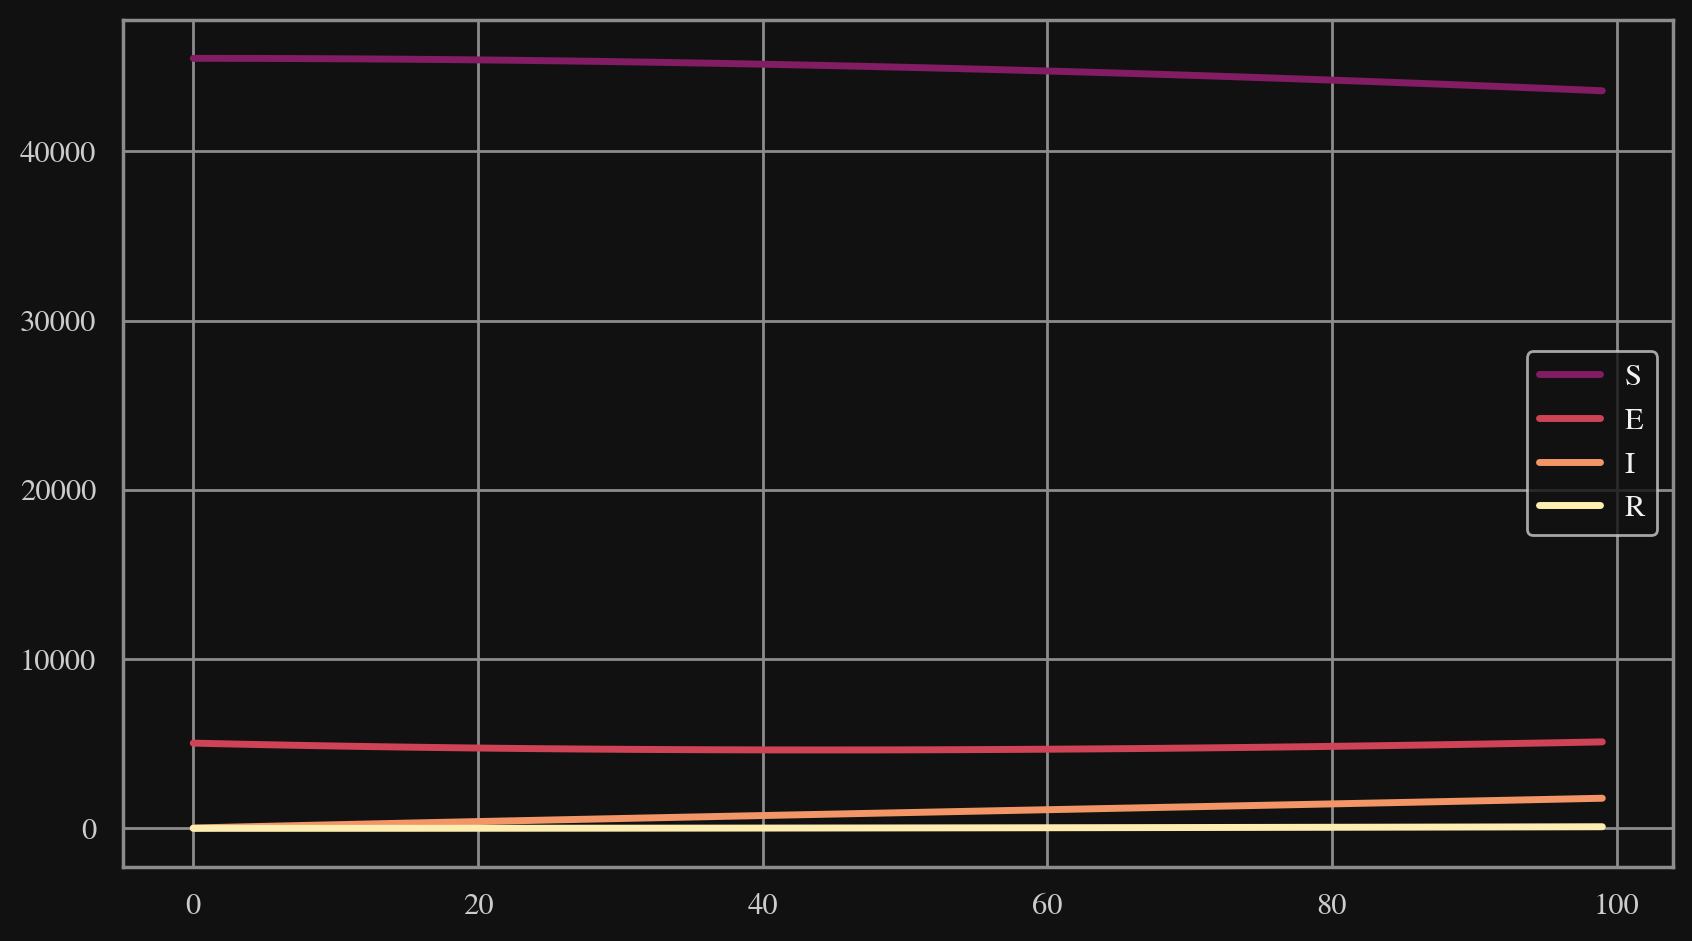

294.6923408716941 9.351021585659364 27.331062786729767 0.011630761246226652


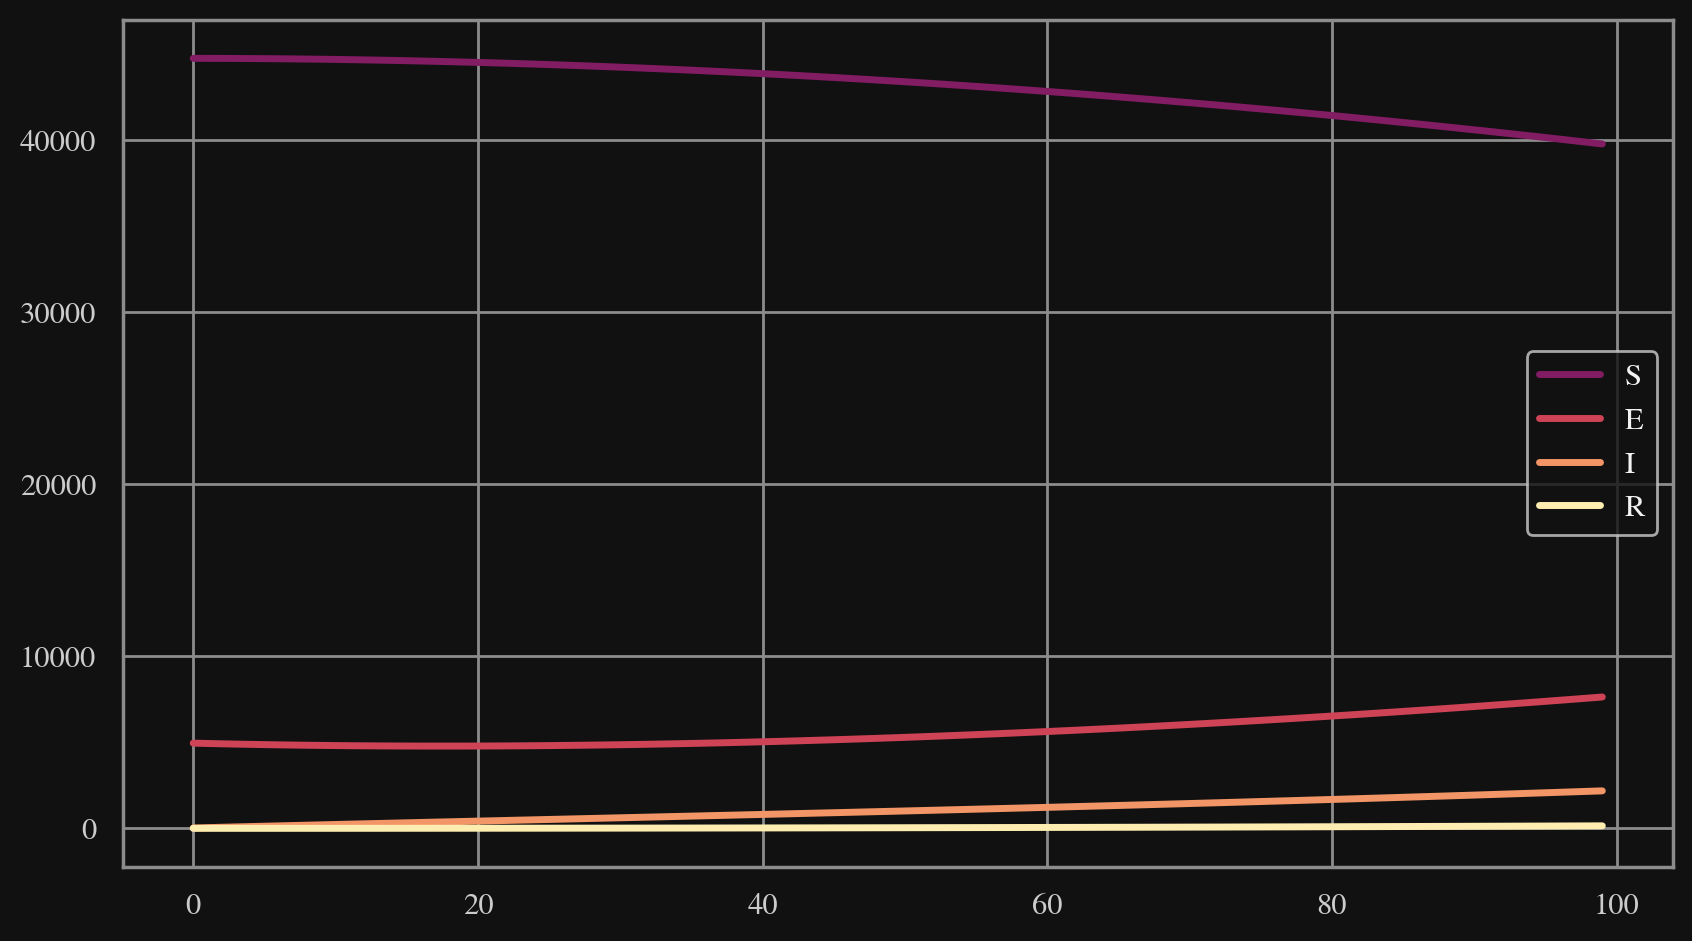

260.47854219379565 4.584938608596049 83.31101894797943 0.07863619841423983


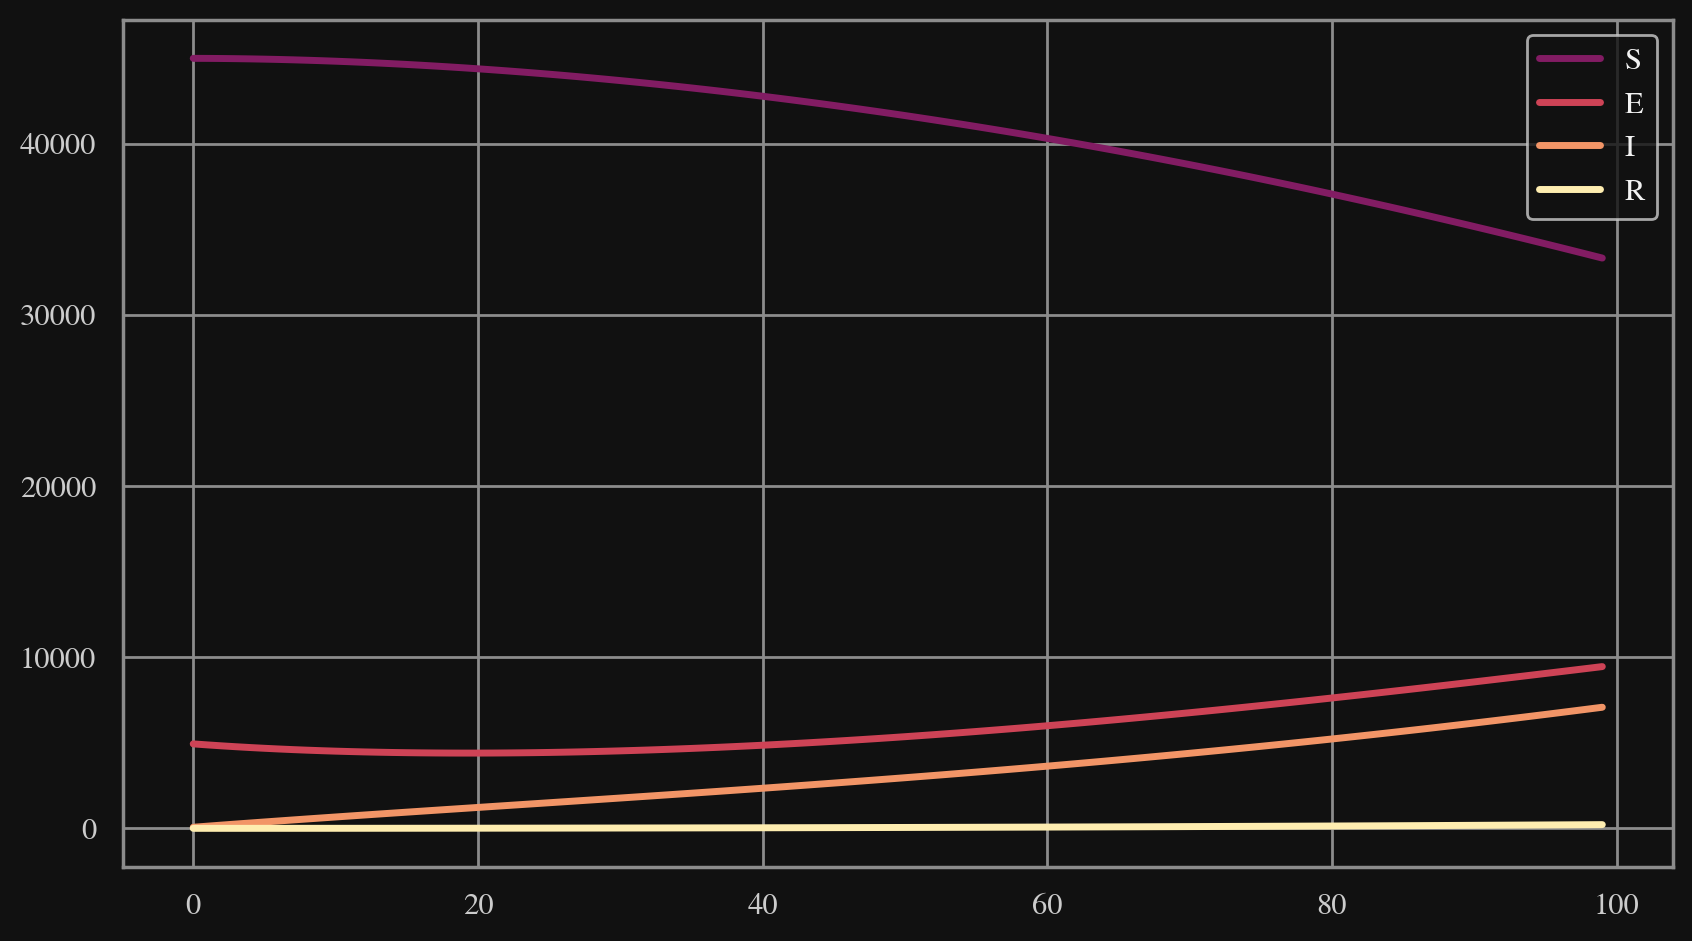

40.371019342620656 2.3091347646340368 69.71135848178652 0.0734935229484474


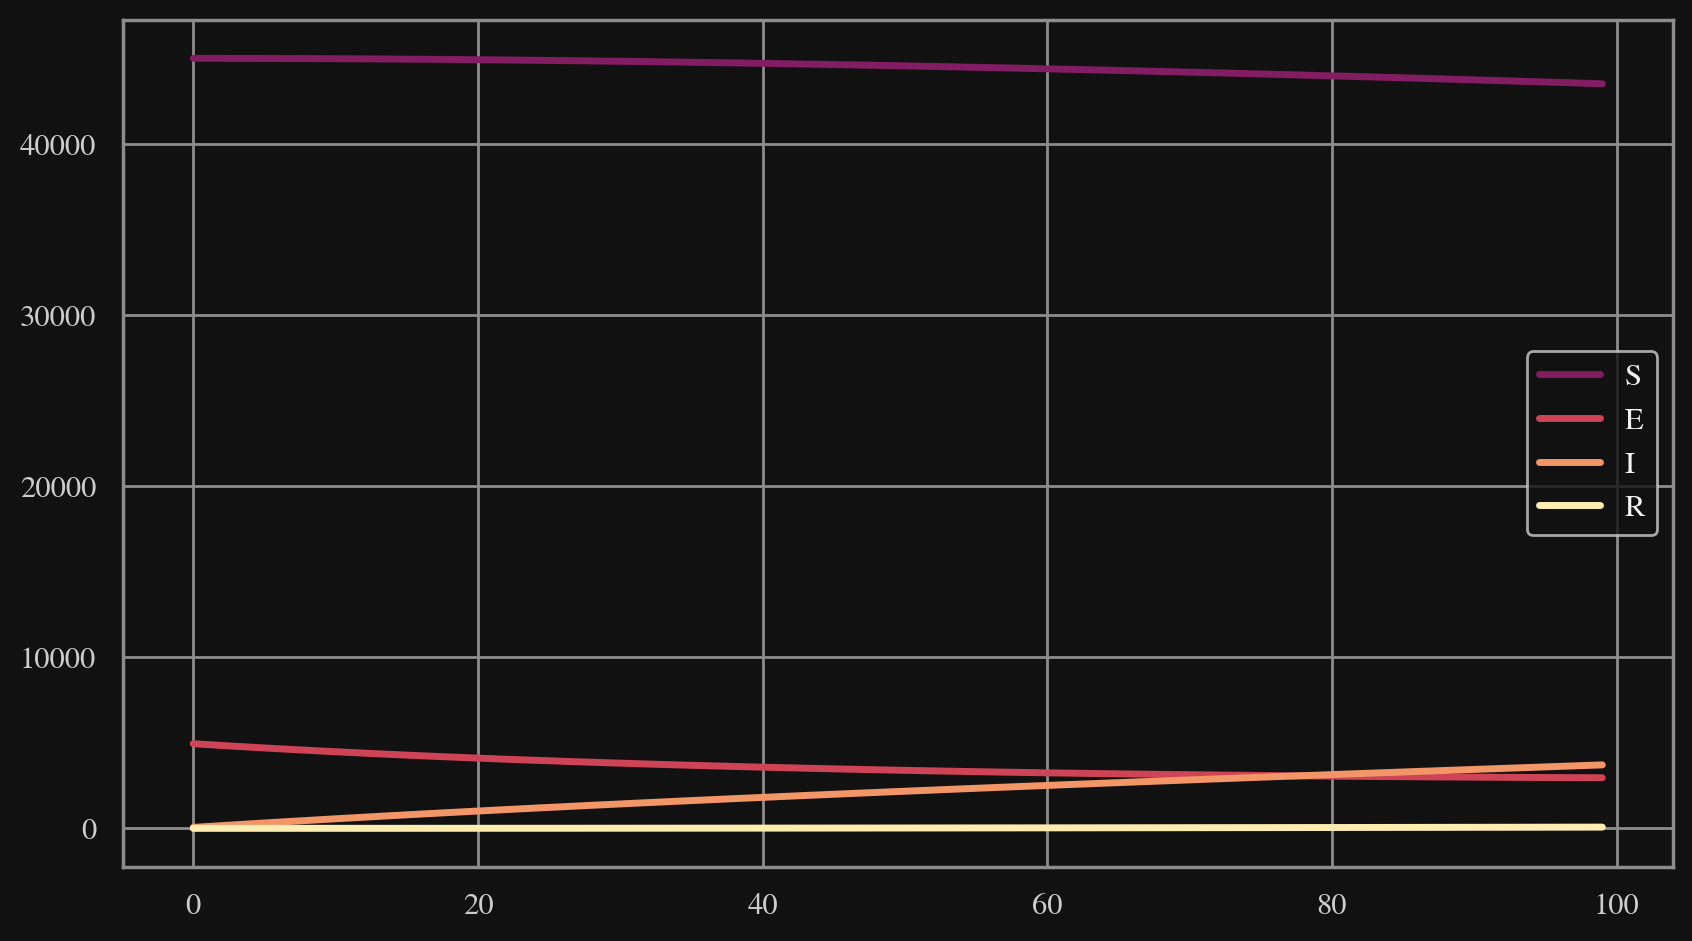

290.7669621026296 2.94218023348003 4.553137842868649 0.07669329370830572


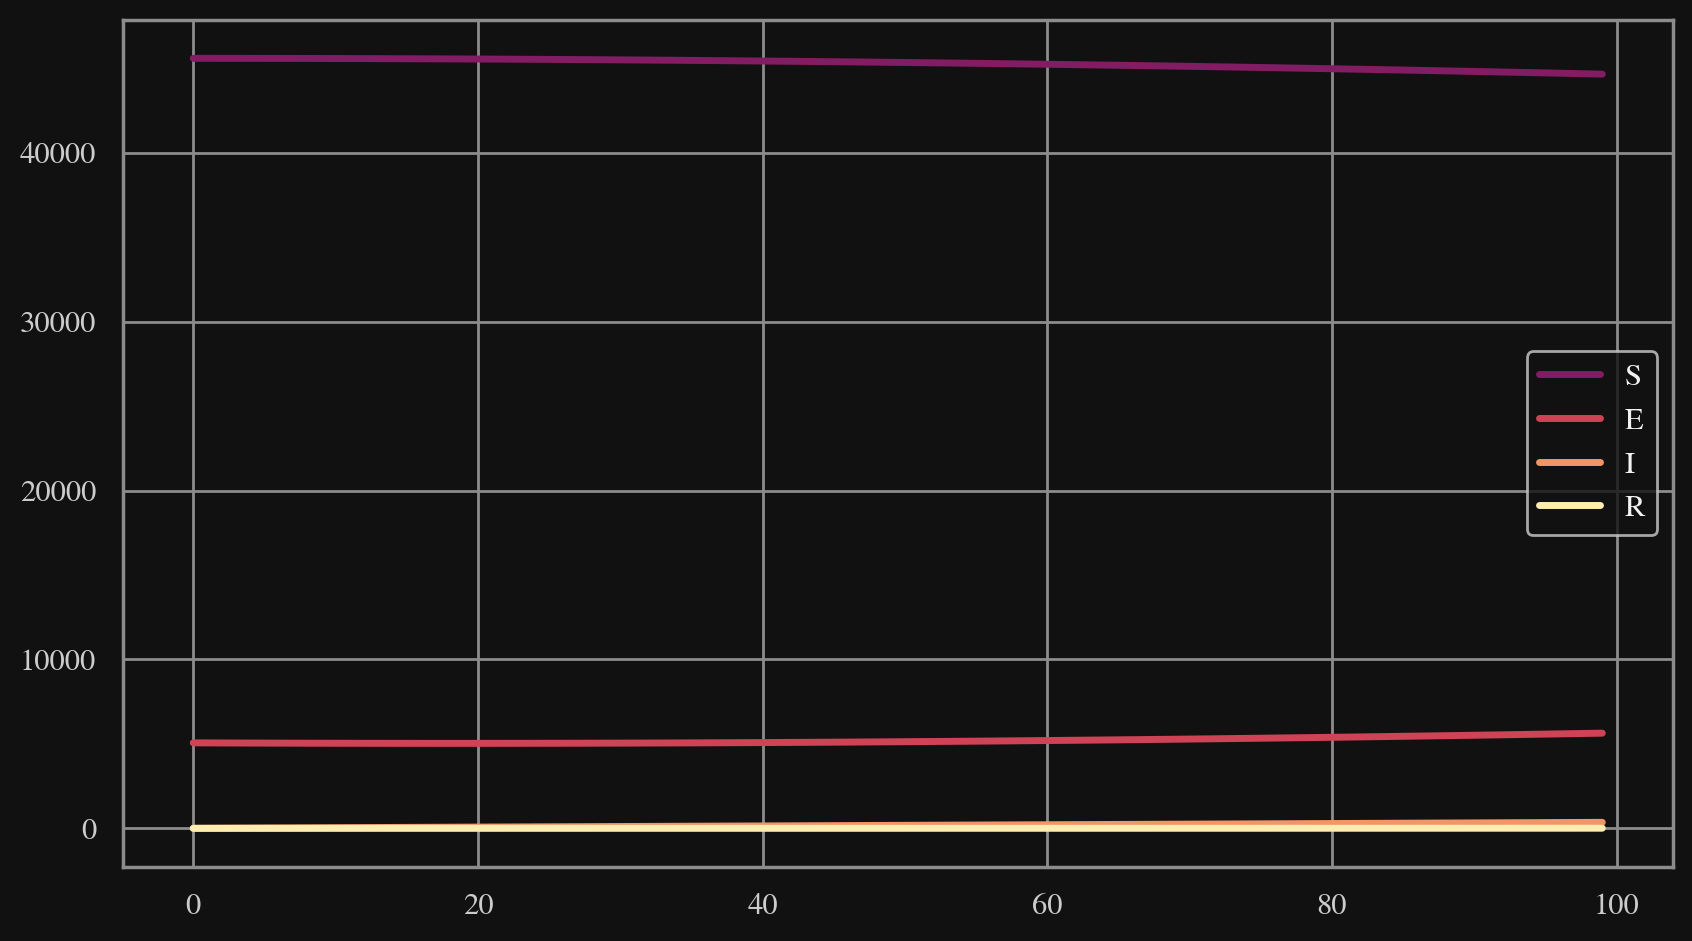

177.69966433263897 2.495482820644204 71.97100218599624 0.055186957276288896


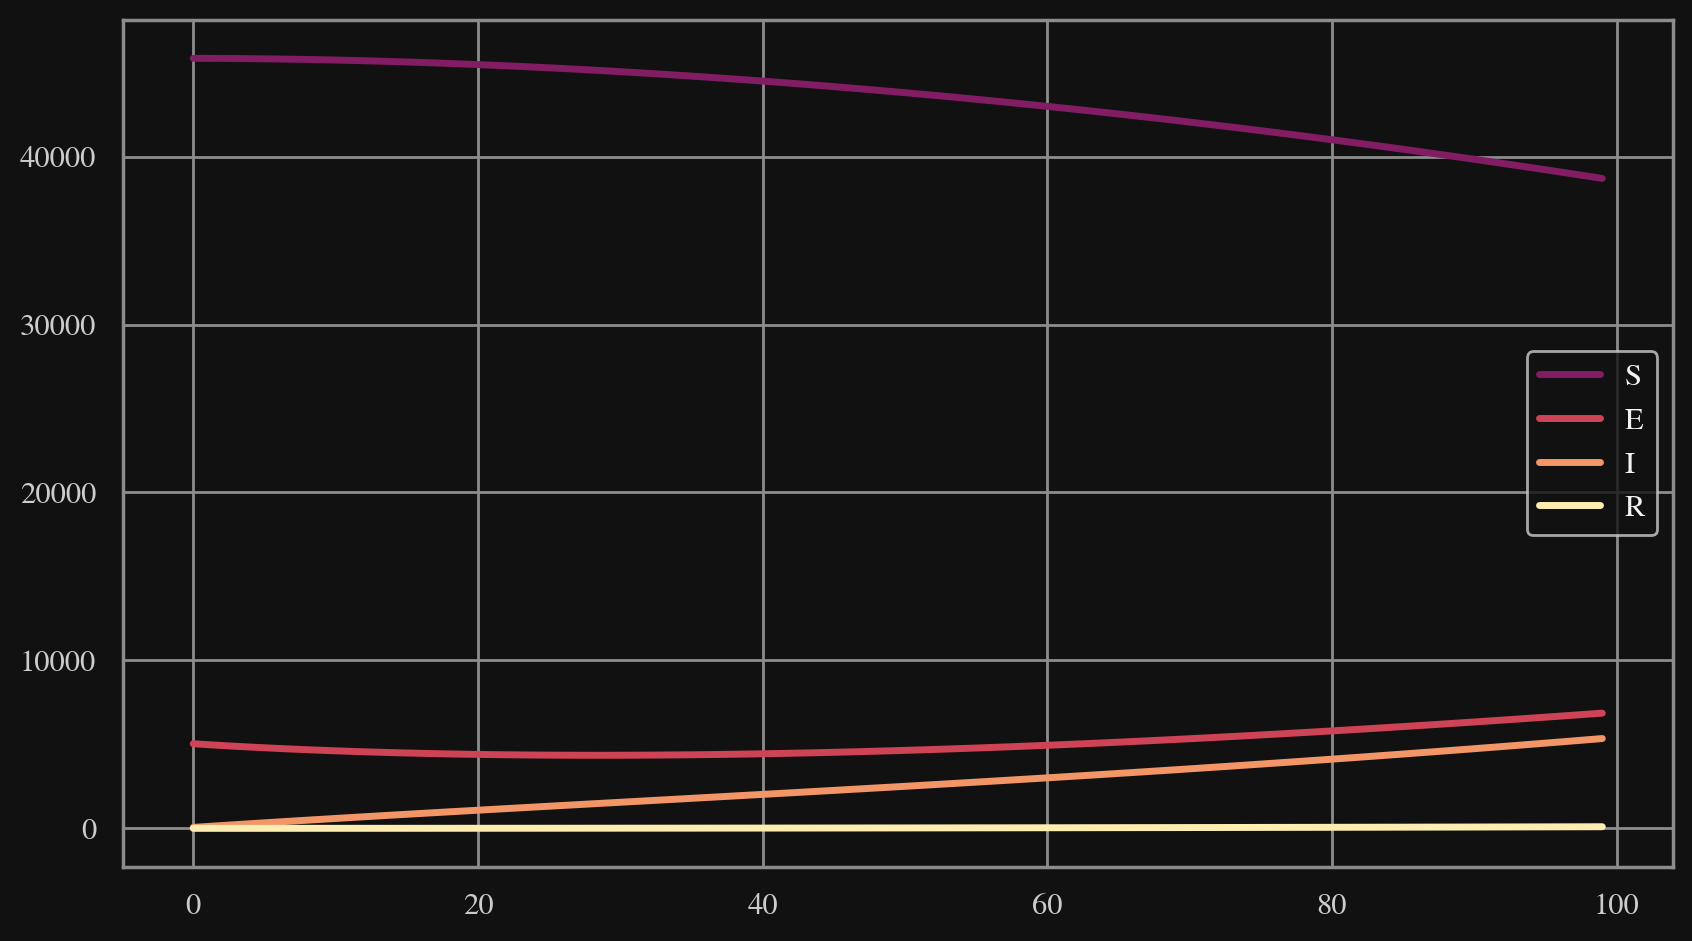

43.007435329027466 3.3567057150353143 19.925558829184563 0.024563164234911672


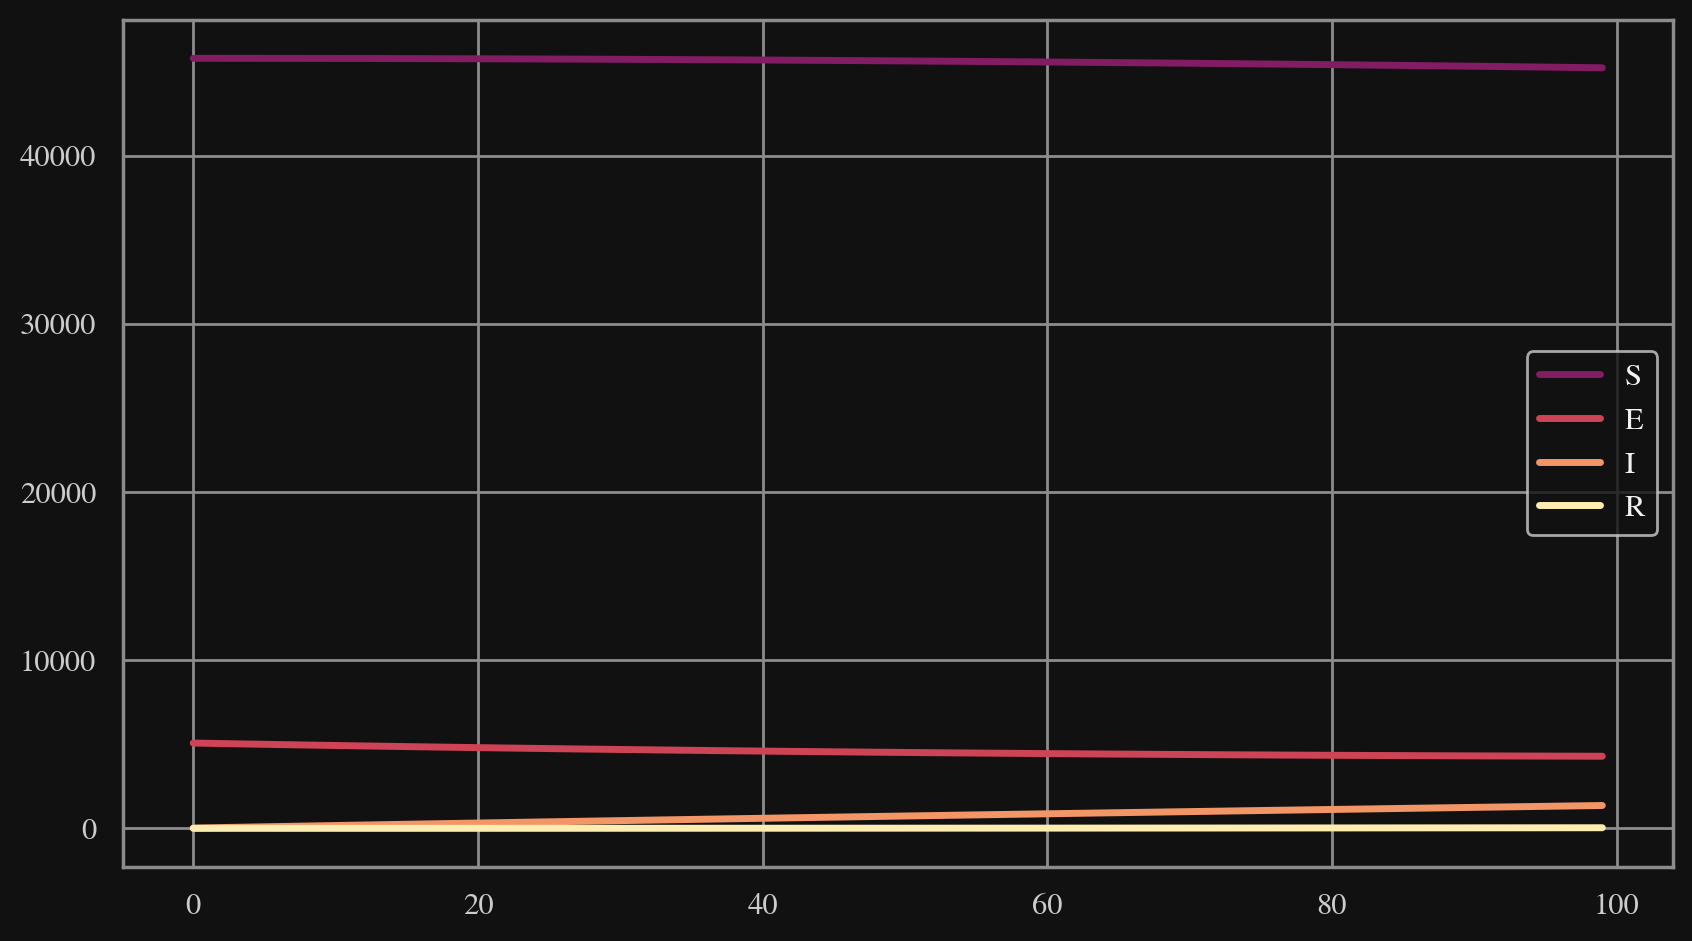

178.85761471549313 2.5622390409244766 19.87188045807452 0.08927559720611872


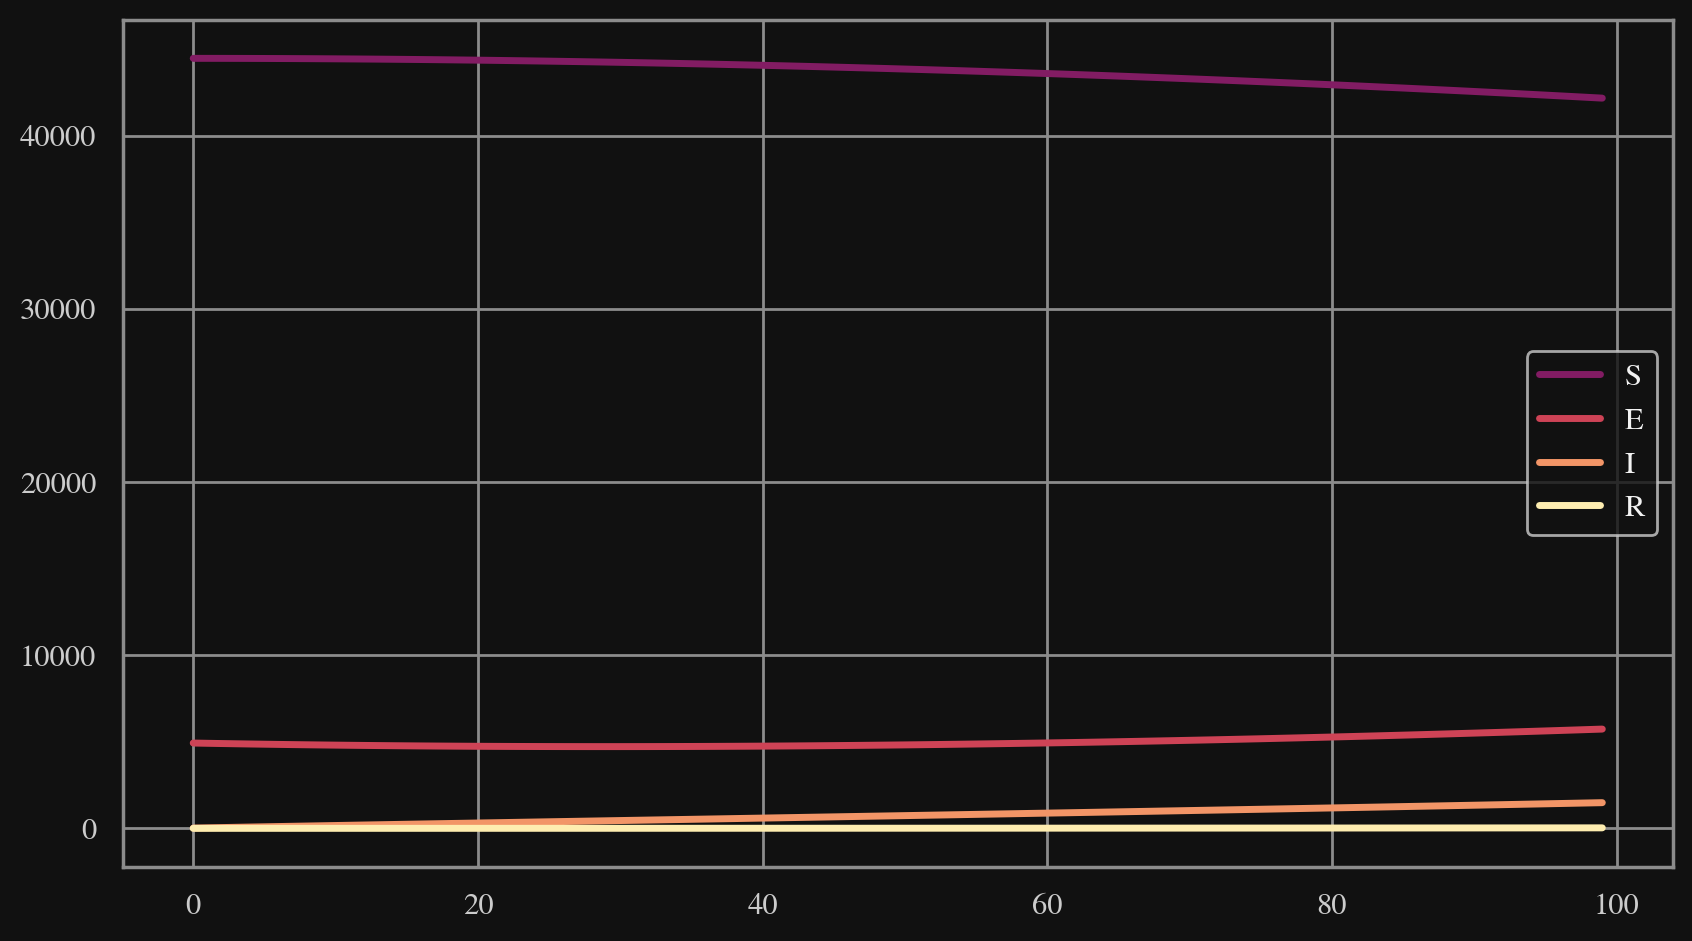

299.45983963333845 8.138438492633789 80.52887966636271 0.09432707918216846


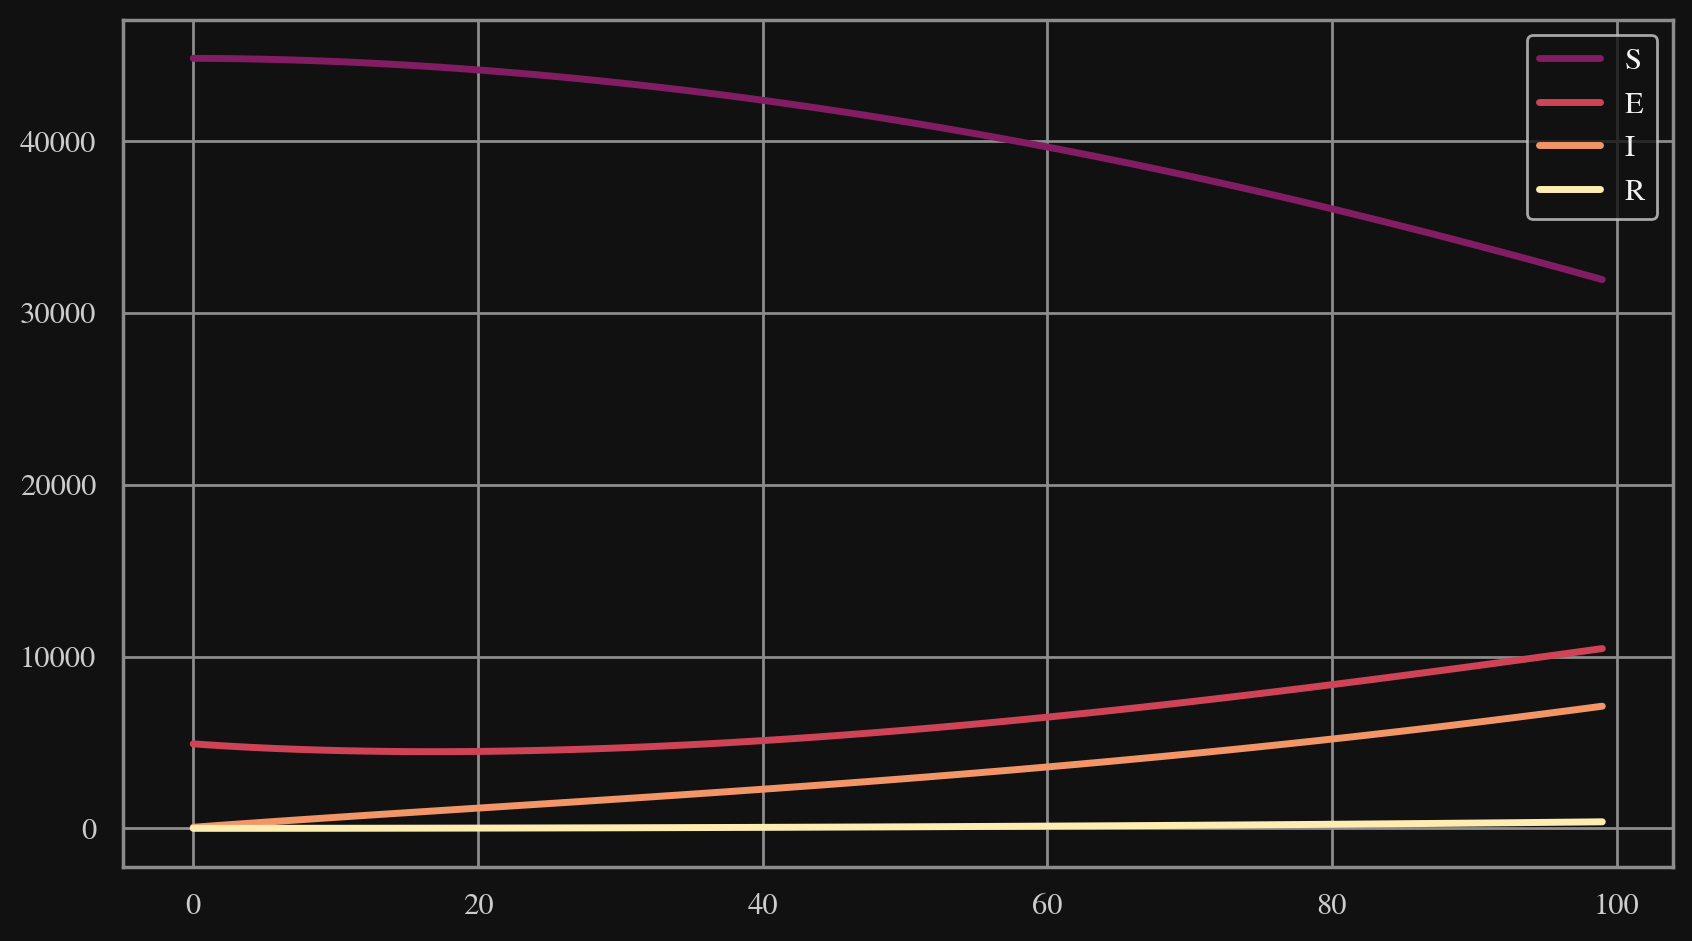

257.8939282087331 2.5036673924184796 71.35233488145987 0.07443156578975509


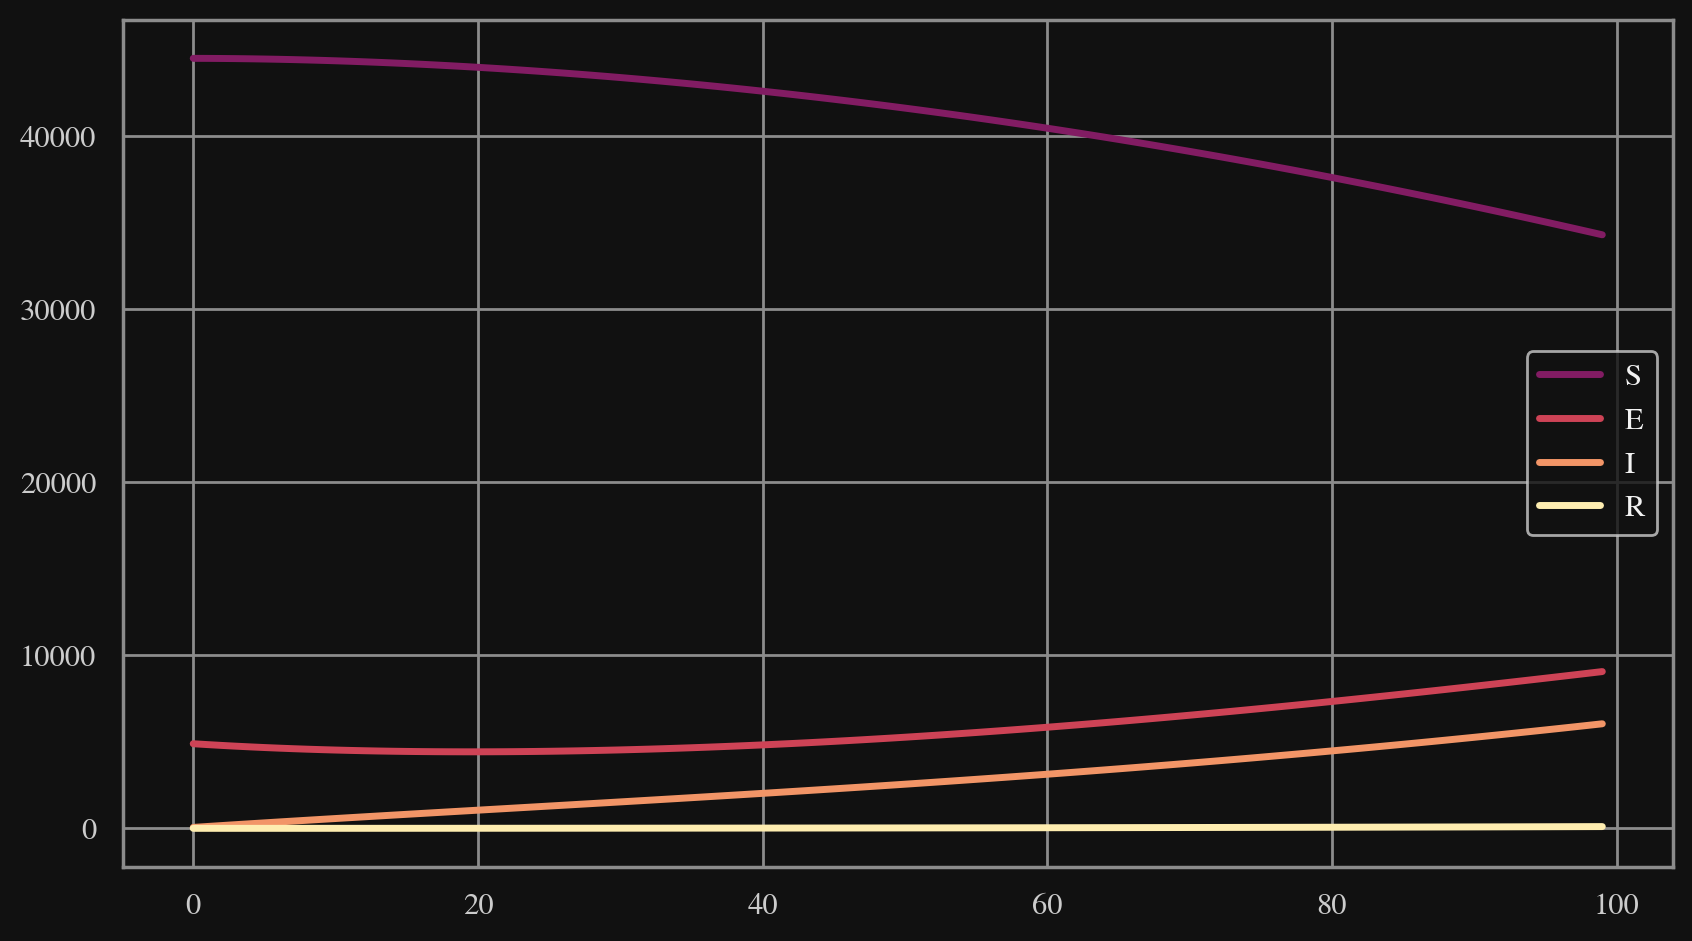

170.78957549116103 6.207556758243868 28.096242143896223 0.07207647507869491


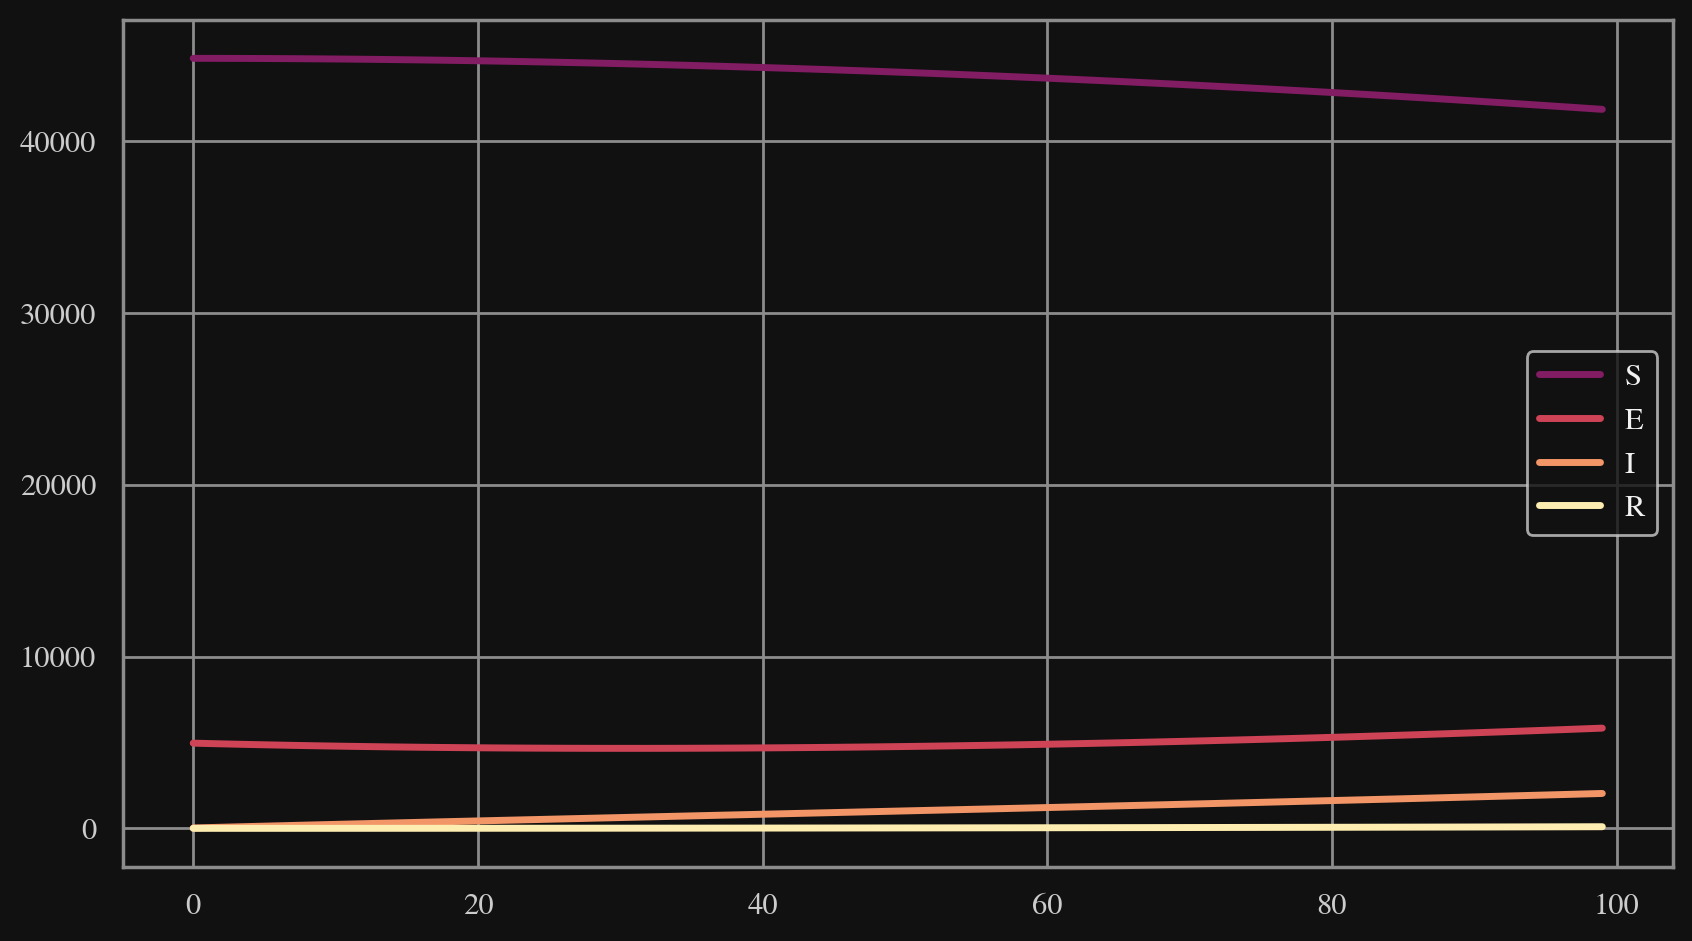

232.60324096740112 7.333800111811846 48.94261490579821 0.0807549000156772


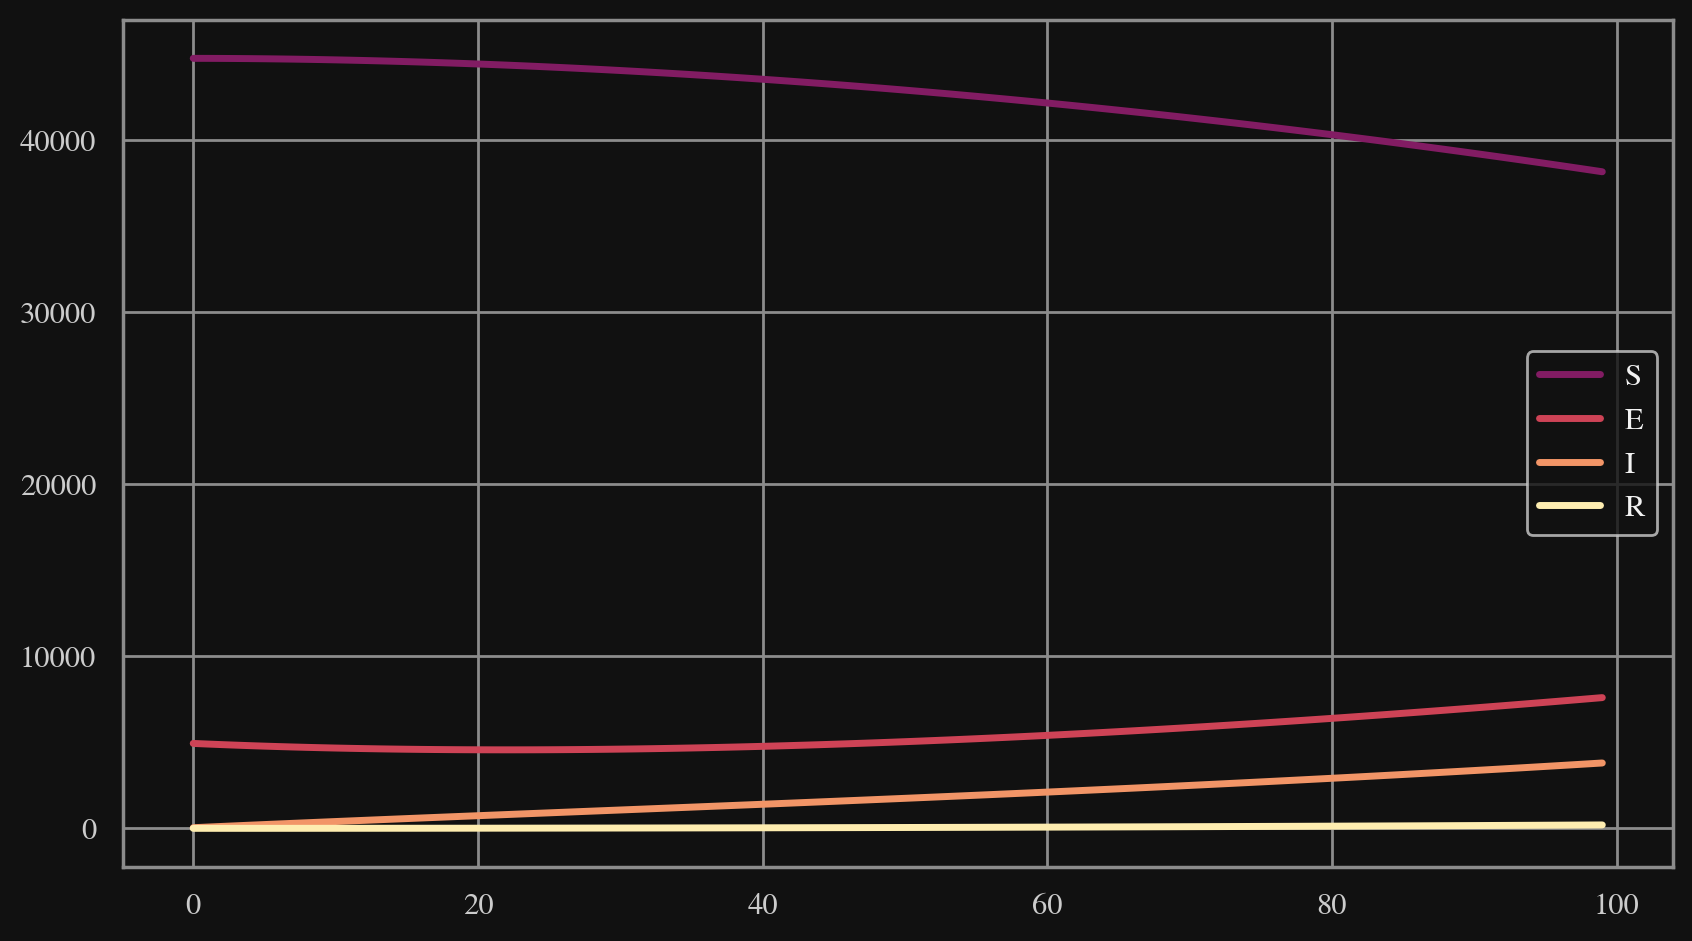

In [242]:
# TODO: country population -- counties vectors
yourdate = '2/28/20'

for jj in np.arange(20):
    N = np.random.randint(1e5,size=distances.shape[0])+100
    S = N*(0.9) -  us_conf[yourdate]
    E = N*0.1
    I = us_conf[yourdate]
    R = us_conf[yourdate]*0

    # (S.sum(),E.sum(),I.sum(),R.sum())

    beta_, gamma_, sigma_, zeta_ = np.random.random(4)*100*[3,0.1,1,0.001]
    print(beta_, gamma_, sigma_, zeta_)

    numcounties = distances.shape[0]
    totalcov = numcounties**2

    # TODO: do something better for these. need to be able to smooth them and set known things (like NYC is problematic etc)
    beta = np.power(proximity,4)/totalcov*beta_ #average numer of contacts per person per day
    zeta = np.random.random((distances.shape))/totalcov*zeta_ # re-susceptible rate 
    sigma = np.random.random((distances.shape))/totalcov*sigma_ # incubation rate
    gamma = np.random.random((distances.shape))/totalcov*gamma_ # rate of recovery

    beta.sum(),gamma.sum(),sigma.sum(),zeta.sum()

    tottime = 100
    timeseries = np.zeros((4,tottime,numcounties))
    for days in np.arange(tottime):
        S,E,I,R,beta,zeta,sigma,gamma = SEIRS(S,E,I,R,N,beta,zeta,sigma,gamma)
        timeseries[:,days,:] = [S,E,I,R] 

    x = ''.join(random.choices(string.ascii_letters + string.digits, k=16))
    np.save('results/umcov-'+x+'.npy',timeseries)
    x

    plt.plot(timeseries[0,:,:].mean((1)))
    plt.plot(timeseries[1,:,:].mean((1)))
    plt.plot(timeseries[2,:,:].mean((1)))
    plt.plot(timeseries[3,:,:].mean((1)))
    plt.legend(['S','E','I','R'])
    plt.show()

In [226]:
# ONLY RUN IF YOU NEED A BREAK AND WANT SOME 
# ART ON YOUR SCREEN WHEN YOU COME BACK


# plt.plot(timeseries[0,:,:])
# plt.plot(timeseries[1,:,:])
# plt.plot(timeseries[2,:,:])
# plt.plot(timeseries[3,:,:])
# plt.legend(['S','E','I','R'])
# plt.show()

EUGwkFBvruJHPwWw
